In [1]:
import pandas as pd
import numpy as np
import csv
import copy
import altair as alt
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
import string
from statsmodels.distributions.empirical_distribution import ECDF
import re
from unidecode import unidecode
from collections import defaultdict
import requests # For REST calls
import json # for modelling objects in the JSON format
import os
import csv
import ast
from wikipedia2vec import Wikipedia2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_samples

alt.data_transformers.enable('default', max_rows=None)  #renders if the df has more than 5000 rows

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giang\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


DataTransformerRegistry.enable('default')

In [2]:
path = "E:\Gianluca\Master Big Data Pisa\Progetto_Finale\Agricolo\Facebook\csv_docs_def\comments4_no_spam_nan.csv"
comments_no_nan = pd.read_csv(path, parse_dates=["post_date"], quotechar='"', quoting=csv.QUOTE_ALL, encoding="utf-8", low_memory=False)

In [3]:
def replace_dots(text):
    # This pattern will match sequences of words separated by dots but not acronyms.
    # Acronyms are sequences of single uppercase letters separated by dots and potentially followed by a dot.
    #pattern = r'\b(?:\w+\.\w{2,}|\w{2,}\.\w+)(?:\.\w+)*\b'
    pattern = r'\b(?:[a-zA-Z]+\.[a-zA-Z]{2,}|[a-zA-Z]{2,}\.[a-zA-Z]+)(?:\.[a-zA-Z]+)*\b'
    #pattern = r'\b(?!\d{1,2}\.\d{1,2}\.\d{2,4}\b)(?=\w*[^\d]\w*)(?:\w{2,}\.\w+|\w+\.\w{2,})(?:\.\w+)*\b'

    def replacement(match):
        # Replace dots with spaces in the matched string
        return match.group(0).replace('.', '. ')
    
    # Use re.sub to replace the matched pattern with the replacement function
    return re.sub(pattern, replacement, text)

def replace_commas(text):
    # This pattern will match sequences of words separated by dots but not acronyms.
    # Acronyms are sequences of single uppercase letters separated by dots and potentially followed by a dot.
    #pattern = r'\b(?:\w+\.\w{2,}|\w{2,}\.\w+)(?:\.\w+)*\b'
    pattern = r'\b(?:[a-zA-Z]+,[a-zA-Z]{2,}|[a-zA-Z]{2,},[a-zA-Z]+)(?:,[a-zA-Z]+)*\b'
    #pattern = r'\b(?!\d{1,2}\.\d{1,2}\.\d{2,4}\b)(?=\w*[^\d]\w*)(?:\w{2,}\.\w+|\w+\.\w{2,})(?:\.\w+)*\b'

    def replacement(match):
        # Replace dots with spaces in the matched string
        return match.group(0).replace(',', ', ')
    
    # Use re.sub to replace the matched pattern with the replacement function
    return re.sub(pattern, replacement, text)

def clean_text(text):
    # Rimuove gli articoli con apostrofi come "l'", "all'", ecc.
    cleaned_text = re.sub(r"^(l|all|d|nell|sull|coll|dall|dell|all|quell|quest)'", '', text)
    return cleaned_text

def remove_leading_point(text):
    # Define a pattern to match words starting with a point
    #pattern = r'\W\.\b(?=\w+)'
    pattern = r'(?:(?<=\s)|(?<=^))\.\b(?=\w+)'

    # Use re.sub to remove the leading point from matched words
    result = re.sub(pattern, '', text)

    return result

def remove_ending_point(text):
    # Define a pattern to match words starting with a point
    #pattern = r'\W\.\b(?=\w+)'
    pattern = r'(?:\b)\.$'

    # Use re.sub to remove the leading point from matched words
    result = re.sub(pattern, '', text)

    return result

def remove_hyphen(text):
    # Define a pattern to match words starting with a point
    #pattern = r'\W\.\b(?=\w+)'
    pattern = r'(?<=[a-zA-Z])-(?=[a-zA-Z])'

    # Use re.sub to remove the leading point from matched words
    result = re.sub(pattern, ' ', text)

    return result

def remove_link(text):   
    
    pattern = r'\bhttps?\S+|\bcom/share\S+|\bstory_fbid=\S+|\bcom/story\S+'
    result = re.sub(pattern, '', text)

    return result

def transform_text(text):
    text = str(text).lower()
    text = unidecode(text)
    text = replace_dots(text)
    text = replace_commas(text)
    text = remove_leading_point(text)
    text = remove_hyphen(text)
    text = remove_link(text)
    return text

In [4]:
def remove_receiver(row):
    if row["level"] > 0 and isinstance(row["content"], str):
        receiver_name_len = len(row["type"].split()) - len(row["author"].split()) - 7
        if len(row["content"].split()) >= receiver_name_len:
            token_list = row["content"].split()
            del token_list[:receiver_name_len]
            content_without_receiver = " ".join(token_list)
            row["content"] = content_without_receiver
    return row

# Apply the function to each row
comments_truncated = comments_no_nan.apply(remove_receiver, axis=1)

In [5]:
# This line opens the file from the file system, the file is in the same folder of the notebook and it is opened in "read-only mode"
with open("config.json", 'r') as json_file:
    config = json.load(json_file) # load the json object inside the config file
    KEY = config['d4science_KEY'] # this is the key we will be using for REST calls

In [7]:
TAGME_ENDPOINT = "https://tagme.d4science.org/tagme/tag"
LANG = "it" # Also works in italian and german

In [8]:
def query_tagme(text, long_text=False):
    payload = {"text": text, "gcube-token": KEY, "lang": LANG}
    if long_text:
        # long_text is by defaul false, but if specified by the user, we set the window size at 5
        payload["long_text"] = 5
    r = requests.post(TAGME_ENDPOINT, payload)
    if r.status_code != 200:
        raise Exception("Error on text: {}\n{}".format(text, r.text))
    return r.json()

In [ ]:
# Try changing the min_rho parameter and see how it impacts the returned entities
def get_tagme_entities(tagme_response, min_rho=0.3, min_link_probability=0.1):
    ann = tagme_response["annotations"]
    ann = [a for a in ann if a["rho"] > min_rho and a["link_probability"] > min_link_probability] # filter all the annotations with a rho score lower than the threshold
    return ann

def def_value(): 
    return 0

output_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
with open(output_file, 'a', encoding='utf-8', newline='') as handle_w:
    csv_writer = csv.writer(handle_w, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # se il file è vuoto lungo la prima riga metto l'header
    file_size = os.path.getsize(output_file)  # Find the size of csv file
    if file_size == 0:     # if size is empty 
        headers = ["index", "entities"]
        csv_writer.writerow(headers)
    count = 0
    for index, row in comments_truncated[120000:].iterrows():
        count = count + 1
        print(count)
        text = row["content"]
        try:
            resp = query_tagme(transform_text(text), long_text=True) 
        except:
            continue
        entities = get_tagme_entities(resp, min_rho=0.15, min_link_probability=0)
        csv_writer.writerow([index, entities])
            

In [6]:
def def_value(): 
    return 0

entities_freq = defaultdict(def_value)
entities_flag = {}
entities_link_prob = set()
input_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
count = 0
with open(input_file, 'r', encoding='utf-8', newline='') as handle_r:
    reader = csv.DictReader(handle_r)
    for row in reader:
        row_entities = ast.literal_eval(row["entities"])
        if len(row_entities) == 0:
            continue
        else:
            for entity in row_entities:
                try:
                    if entity["title"] not in entities_flag:
                        entities_flag[entity["title"]] = 0
                    if entity["link_probability"] == 1 and entity["rho"] == 0.5:
                        entities_link_prob.add(entity["title"])
                    if entity["link_probability"] != 1 or entity["rho"] != 0.5:
                        entities_flag[entity["title"]] = 1
                except:
                    pass
                try:
                    entities_freq[entity["title"]] = entities_freq[entity["title"]] + 1
                except:
                    count = count + 1
        

In [9]:
# [title for title in entities_flag if entities_flag[title] == 0]
sorted([title for title in entities_flag if entities_flag[title] == 0], key = lambda x: -entities_freq[x])
# print(len([title for title in entities_flag if entities_flag[title] == 0]))

['Rosario Vieni',
 'Non-A',
 'Alex Kinvi-Boh',
 'Hanno tutti ragione',
 'Noi saremo tutto',
 'Dascălu',
 'Paula Seguí',
 'Chi si ferma è perduto',
 'Sei fantastica',
 "Che'Nelle",
 'Pötréte',
 'Scarpe grosse',
 'Nõo',
 'Ancora... grazie a tutti',
 'Emilia Docet',
 'Henri Salvano',
 'Semo La',
 'Greetings from L.A.',
 'Guerra fra poveri',
 'Un bellissimo paese',
 'Viva le donne!',
 'Amedeo Stenti',
 'Alin Bota',
 'La bella gente',
 'William Rarità',
 'I senza Dio (film 1955)',
 'Lavaré',
 'Strání',
 'Lamar Mady',
 'Noi ci saremo',
 'Pietro Bordo di San Superano',
 'Spandiletame',
 'Strelitzia',
 'Guida Michelin',
 'Peter Zelenský',
 'Memento audere semper',
 'Tutti i santi giorni',
 'E io ci sto',
 'La vita è bella (film 1997)',
 'Andrea Cucino',
 'G I R L',
 'SEEE',
 'Questa ragazza è di tutti',
 'Insieme per forza (film 1991)',
 'Malta Amateur Athletic Association',
 'Joseph Ndo',
 'Giacomo Del Gratta',
 'Sono solo parole',
 'AlterVista',
 'Come Dio comanda (film)',
 'Decídete',
 'Fra

In [91]:
len(entities_link_prob)

1206

In [93]:
sorted(list(entities_link_prob), key = lambda x: -entities_freq[x])

['Tutte lo vogliono',
 'Unione europea',
 'Hazdayi Penso',
 'Worstward Ho',
 'Piacé',
 'Tutte e nessuna',
 'Buona Domenica',
 "Storia dell'agricoltura italiana",
 'Carne sintetica',
 'Circo Massimo',
 'Cappello a cono di paglia',
 'Dalla vostra parte',
 'Forza Italia (1994)',
 'Teymur Məmmədov',
 'Provincia di Salerno',
 'Imposta sul reddito delle persone fisiche',
 'La deve smettere!',
 'Provincia di Varese',
 'Provincia di Vicenza',
 'Glifosato',
 'Giorgia Meloni',
 'Bill Gates',
 'Quota latte',
 'Noi con voi',
 'Provincia di Teramo',
 'Assolutamente sì',
 'Provincia di Caserta',
 'Alfabeto fonetico internazionale',
 'Provincia di Sondrio',
 'Ambientalismo',
 'Rosario Vieni',
 'Scuderia Ferrari',
 'Sai xChé?',
 'Allevamento intensivo',
 'Movimento 5 Stelle',
 'Gmail',
 'Non-A',
 'Risorgimento',
 'Armiamoci e partite!',
 "Economia d'Italia",
 'Loro ed io',
 'Intelligenza artificiale',
 'Buona giornata e...',
 'I più grandi di tutti',
 'Se per te',
 'Australia',
 'Le vostre richieste',

In [28]:
len(entities_freq.keys())

12502

In [33]:
sorted(entities_freq.items(), key=lambda x: -x[1])

[('Italia', 7236),
 ('Agricoltura', 6736),
 ('Dio', 3978),
 ('Europa', 3063),
 ('Roma', 2631),
 ('Agricoltore', 2276),
 ('Tutte lo vogliono', 2107),
 ('Politica', 1826),
 ('Unione europea', 1719),
 ('Italiani', 1671),
 ('Sindacato', 1339),
 ('Suolo', 1165),
 ('Comitato Olimpico Internazionale', 1112),
 ('VI secolo', 1099),
 ('Lavoro', 1074),
 ('Facebook', 1074),
 ('Bruxelles', 1026),
 ('Francia', 1011),
 ('Governo', 916),
 ('Euro', 855),
 ('Germania', 841),
 ('Alimento', 823),
 ('Homo sapiens', 776),
 ('Coldiretti', 761),
 ('Letame', 756),
 ('Frutta', 696),
 ('Triticum', 692),
 ('Verdura', 685),
 ('Avanti!', 681),
 ('Roma (città antica)', 670),
 ('Marco Fanno', 664),
 ('Produzione', 634),
 ('Popolo', 616),
 ('Terra', 613),
 ('Roberto Magari', 595),
 ('Vita', 584),
 ('Multinazionale', 583),
 ('Forza', 562),
 ('Insecta', 553),
 ('Hazdayi Penso', 551),
 ("Nazionale di calcio dell'Italia", 543),
 ('Trattore agricolo', 515),
 ('Supermercato', 515),
 ('Olio di oliva', 513),
 ('Grazie a tutti

In [10]:
ENTITIES_BIN = {"Tutte lo vogliono", "Comitato Olimpico Internazionale", "VI secolo", "Homo sapiens", "Avanti!", "Marco Fanno", "Roberto Magari", "Forza", 
"Hazdayi Penso", "Grazie a tutti", "Worstward Ho", "Con un ma e con un se", "Piacé", 
"Verissimo - Tutti i colori della cronaca", "Tutte e nessuna", "Così è (se vi pare)", "Bene (filosofia)",
"Buona giornata", "Con voi (singolo)", "Buona Domenica", "Uno di noi (serie televisiva)", "Essere", "Sistema internazionale di unità di misura",
"Grazie mille", "Tempo", "Grazia (teologia)", "PHP", "Fata", "Provincia di Carbonia-Iglesias", "Cappello a cono di paglia",
"Ora", "Dalla vostra parte", "Silicio", "Po", "Uno come te", "Parole sante", "Cio (città antica)", "Mica", "L'Ora", "Giovanni Battista Zitti",
"Anno", "La nostra vita (film)", "Chi (periodico)", "Viva l'Italia (film)", "Teymur Məmmədov", "Partito dei Comunisti Italiani",
"Grazie (mitologia)", "Gli orgogliosi", "Eccellenza (calcio)", "W l'Italia", "Sei bellissima/Spiagge di notte", "Era (tempo)", "Non Mollare",
"Giovanni de Primis", "Irene Grandi", "Ugo di La Certa", "La deve smettere!", "Uno di noi (programma televisivo)", "Parola", "Simbolo",
"Svegliatevi!", "E già", "Peccato", "Tè", "Ora o mai più (film)", "Io (psicologia)", "Tipo (Pokémon)", "Selenio", "La Porcherie",  
"Fa (nota)", "Si (nota)", "Mese", "Molla", "Augure", "Pensiero", "Dino Grandi", "Giovanni La Magna", "Berillio",
"Tutti a casa", "Buona vita", "Tutto tace", "Rainer Troppa", "Bla Bla Bla", "Dar'a", "Guido Possa", "Federico Paghi", ".com",
"A testa alta (film 2004)", "Cinema", "Ragazzi (atletica leggera)", "Giovanni Fondelli", "Noi con voi", "Una di troppo", "A casa nostra",
"Io (filosofia)", "Assolutamente sì", "Grazie a tutti (programma televisivo)", "Belisario Vinta", "Poesia", "Buonasera con...",
"Arte", "Ferro", "E un'altra cosa...", "Alfabeto fonetico internazionale", "Mario Abbiate", "Oggi (rivista)", "Sé (coscienza)", "Nulla", "Domenica",
"Marco D'Altrui", "VI secolo a.C.", "Non è per sempre", "Non più di uno", "Rosario Vieni", "Adesso o mai", "Specie", "I migliori del mondo",
"Con il cuore", "Grazie di tutto (film)", "Da stasera/La vita vista da un aereo", "Fondo Ambiente Italiano", "Mettā", "Sai xChé?", "E non sai",
"Titanio", "Sistema consuetudinario statunitense", "World Wide Web", "Categoria (Pokémon)", "Calcio (elemento chimico)", "Basso elettrico",
"Genere letterario", "Lei è (album)", "Aristotele", "Gmail", "La stessa barca", "Mano", "Buon pomeriggio (Canale 5)",
"Per fortuna", "Non-A", "Testa", "Basso (voce)", "Grado giorno", "Loro ed io", "Casa da gioco", "Io ci sarò (Piero Pelù)", "Il meglio di...", 
"Pronome personale", "Questo e quello", "Buona giornata e...", "I più grandi di tutti",
"VI Legislatura della Repubblica Italiana", "Non Abbiamo Bisogno", "Forti e Liberi", "Mente", "Saro (generale)",
"Tastiera (musica)", "Se per te"}

for title in entities_flag :
    if entities_flag[title] == 0:
        ENTITIES_BIN.add(title)

CORRECTIONS = {
    "Signoria cittadina": "Dio", 
    "Nazionale di calcio della Francia": "Francia", 
    "À San Remo": "Sanremo", 
    "Virtual Address eXtension": "Vaccino", 
    "Lingua francese": "Francia", 
    "Canto (musica)": "Manifestazione", 
    "Il Popolo": "Popolo", 
    "Regno di Sardegna": "Sardegna", 
    "Europa (astronomia)": "Europa", 
    "Civiltà romana": "Roma", 
    "Costa": "Prezzo", 
    "Pagliacci (opera)": "Pagliaccio", 
    "Giorgia (cantante 1971)": "Giorgia Meloni", 
    "Massa (fisica)": "Massa (sociologia)", 
    "Nazionale di calcio della Germania": "Germania", 
    "Trattore d'artiglieria": "Trattore agricolo",
    "Nazionale di calcio dell'Italia": "Italia", 
    "Germania nazista": "Germania", 
    "Lingua italiana": "Italiani", 
    "Regno d'Italia": "Italia", 
    "Cantante": "Manifestazione", 
    "Siamo italiani": "Italiani",
    "Che Dio ci aiuti": "Dio", 
    "Associazione Sportiva Roma": "Roma", 
    "Terra e Vita": "Terra", 
    "Viva l'Italia!": "Italia", 
    "Che Dio ti benedica": "Dio",
    "Carne sintetica": "Coltura cellulare",
    "Storia dell'agricoltura italiana": "Agricoltura",
    "Grilli": "Gryllidae",
    "Macron": "Emmanuel Macron",
    "Malta Amateur Athletic Association": "Malta"
    }

In [11]:
len(ENTITIES_BIN)

1038

In [85]:
input_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
with open(input_file, 'r', encoding='utf-8', newline='') as handle_r:
    reader = csv.DictReader(handle_r)
    for row in reader:
        row_entities = ast.literal_eval(row["entities"])
        if len(row_entities) == 0:
            continue
        else:
            for entity in row_entities:
                try:
                    if entity["title"] == "Serra de' Conti":
                        print(row["index"])
                        print(entity)
                        print(comments_truncated.loc[int(row["index"]), "content"])
                        print("--------------------------------------------------------------")
                        break
                except:
                   pass 

180
{'spot': 'serra de conti', 'start': 117, 'link_probability': 1, 'rho': 0.68696129322052, 'end': 131, 'id': 3944, 'title': "Serra de' Conti"}
Nel 1962 circa metà aprile, alla mattina verso le 9,30 ha iniziato  a nevicare più di 10 cm nel giro di poco tempo.  Serra de Conti, provincia di Ancona.
--------------------------------------------------------------


In [12]:
def def_value(): 
    return 0

comments_entites_filtered = []
entities_freq_filtered = defaultdict(def_value)
input_file = "E:/Gianluca/Master Big Data Pisa/Progetto_Finale/Agricolo/Facebook/csv_docs_def/comments_entities.csv"
count = 0
with open(input_file, 'r', encoding='utf-8', newline='') as handle_r:
    reader = csv.DictReader(handle_r)
    i = 0
    for row in reader:
        row_entities = ast.literal_eval(row["entities"])
        comments_entites_filtered.append([int(row["index"]), []])
        if len(row_entities) == 0:
            continue
        else:
            try:
                for entity in row_entities:
                    if entity["title"] in CORRECTIONS:
                        comments_entites_filtered[i][1].append({"spot":entity["spot"], "start":entity["start"], "end":entity["end"], "title":CORRECTIONS[entity["title"]]})
                        entities_freq_filtered[CORRECTIONS[entity["title"]]] = entities_freq[CORRECTIONS[entity["title"]]] + 1
                        continue
                    if entity["title"] in ENTITIES_BIN:
                        continue
                    if entities_freq[entity["title"]] < 37:
                        if entity["rho"] >= 0.5 and entity["link_probability"] >= 0.3:
                            comments_entites_filtered[i][1].append(entity)
                            entities_freq_filtered[entity["title"]] = entities_freq[entity["title"]] + 1
                    else:
                        comments_entites_filtered[i][1].append(entity)
                        entities_freq_filtered[entity["title"]] = entities_freq[entity["title"]] + 1
            except:
                count = count + 1
        i = i + 1
           
                

In [13]:
print(len(entities_freq_filtered))
print(len(entities_freq))

2179
12503


In [14]:
sorted(entities_freq_filtered.items(), key=lambda x: x[1])

[('Coltura cellulare', 1),
 ('Terre rare', 2),
 ('Lantanoidi', 2),
 ('Inseminazione artificiale', 2),
 ('Scia di condensazione', 2),
 ('Tibet', 2),
 ('Vitamina D', 2),
 ("Serra de' Conti", 2),
 ('Governo mondiale', 2),
 ('Radiazione elettromagnetica', 2),
 ('Standa', 2),
 ('Ankara', 2),
 ('Panino imbottito', 2),
 ('Jeremy Irons', 2),
 ('Ennio Morricone', 2),
 ('Ceccano', 2),
 ('Falisci', 2),
 ("Carciofo violetto di Sant'Erasmo", 2),
 ("Sant'Erasmo (Venezia)", 2),
 ('Serravalle Scrivia', 2),
 ('Pino Daniele', 2),
 ("Dumbo - L'elefante volante", 2),
 ('Guerre stellari', 2),
 ('Le donne lo sanno', 2),
 ('Emmanuel Macron', 2),
 ('Un posto al sole (soap opera)', 2),
 ('Cortina di ferro', 2),
 ("L'invasione degli ultracorpi (romanzo)", 2),
 ('Peperino', 2),
 ('Agip', 2),
 ('Ginosa', 2),
 ('Oderzo', 2),
 ('Aeroporti di Roma', 2),
 ('Bastia Umbra', 2),
 ('Taraxacum officinale', 2),
 ('Eutanasia', 2),
 ('Ontario (California)', 2),
 ('Turné', 2),
 ('Eye liner', 2),
 ('Acido urico', 2),
 ('Federc

In [15]:
sorted([x for x in entities_freq_filtered.items() if x[1] >= 13], key=lambda x: x[1])

[('Metano', 13),
 ('Mario Draghi', 13),
 ('Anno luce', 13),
 ('Provincia di Trieste', 13),
 ('W le donne (programma televisivo)', 13),
 ('Agenzia delle entrate', 13),
 ('Impero ottomano', 13),
 ('Il Canto degli Italiani', 13),
 ('Per tutte le volte che... (singolo)', 13),
 ('IN.SI.DIA', 13),
 ('Sandro Pertini', 13),
 ('50 Cent', 13),
 ('Arcangelo Michele', 13),
 ('Ungheria', 13),
 ('Come la penso', 13),
 ('Sergio Mattarella', 13),
 ('Hanoi', 13),
 ('Avellino', 13),
 ('Ghiaccio', 13),
 ('Palazzo Madama (Roma)', 13),
 ('Granducato di Toscana', 13),
 ('Conad', 13),
 ('Democrazia Cristiana', 13),
 ('Provincia di Parma', 13),
 ('Cultivar', 13),
 ('Codice civile italiano del 1942', 13),
 ('Effetto serra', 14),
 ('Lobbi', 14),
 ('Fabrizio Paghera', 14),
 ('Istituto nazionale della previdenza sociale', 14),
 ('Fedez', 14),
 ('Limoncello', 14),
 ('Juventus Football Club', 14),
 ('Spirito Santo', 14),
 ('Trapani', 14),
 ('Uomini veri', 14),
 ('Brindisi', 14),
 ('Via Nomentana', 14),
 ('Lecce', 1

In [62]:
set(entities_freq.keys()) - set(entities_freq_filtered.keys())

{'Somme (fiume)',
 'Afa (meteorologia)',
 'Docente',
 'Circondari della Germania',
 'Pugilato',
 'Ferrovia Milano-Venezia',
 "Agostino d'Ippona",
 'Latticini',
 'Eternità',
 'Sky Italia',
 'Cappello',
 'Sido',
 'Personal computer',
 'Caterva',
 'Tarì',
 'Ben (personaggio)',
 'Numero intero',
 'Terena',
 'Non se ne parla',
 'Fantastica',
 'Ferrovia Porrettana',
 'Tribù',
 'Defibrillatore',
 'Marcia (musica)',
 'Hisato Satō',
 'Mezzogiorno (Italia)',
 'Onnivoro',
 'Paura di Dio',
 'Corpo umano',
 'Le fate (film)',
 'Nino Bixio',
 'Accoppiamento (zoologia)',
 'Patologia',
 'Naso',
 'Augusto Capolino',
 'Denuncia',
 'Compact disc',
 'Nō',
 'Fantastico',
 'Achille Lollo',
 'Odio (sentimento)',
 'Razionalismo',
 'Come vi piace',
 'Costanza (Germania)',
 'Birra Moretti',
 'Baraka (personaggio)',
 'Paina-Brugazzo',
 'Trazione extra-orale',
 'Marina militare',
 'Terra (esogeologia)',
 'Indicatore della situazione economica equivalente',
 'Energia potenziale elettrica',
 'Ribellione della macchi

# Wikipedia2Vec

In [16]:
MODEL_FILE = r"E:\Gianluca\Master Big Data Pisa\Progetto_Finale\Agricolo\Facebook\itwiki_20180420_100d.pkl\itwiki_20180420_100d.pkl"
wiki2vec = Wikipedia2Vec.load(MODEL_FILE)

c:\Users\giang\anaconda3\envs\env_master\Lib\site-packages\joblib\numpy_pickle.py:230: UserWarning: The memmapped array [[107  97]
 [124 112]
 [122 108]
 ...
 [  0   0]
 [  0   0]
 [  0   0]] loaded from the file E:\Gianluca\Master Big Data Pisa\Progetto_Finale\Agricolo\Facebook\itwiki_20180420_100d.pkl\itwiki_20180420_100d.pkl is not byte aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or PyTorch. To get rid of this warning, regenerate your pickle file with joblib >= 1.2.0. See https://github.com/joblib/joblib/issues/563 for more details
  warnings.warn(message)
c:\Users\giang\anaconda3\envs\env_master\Lib\site-packages\joblib\numpy_pickle.py:230: UserWarning: The memmapped array [[ 116589   53012]
 [ 134782   62437]
 [6811053  887006]
 ...
 [      0       0]
 [      0       0]
 [      0       0]] loaded from the file E:\Gianluca\Master Big Data Pisa\Progetto_Finale\Agricolo\Facebook\itwiki_20180420_100d.pkl\itwiki_20180420_100d.

In [17]:
def get_entity_vector(e):
    try:
        emb = wiki2vec.get_entity_vector(e)
    except:
        raise Exception("Entity vector {} not found\n".format(e))
    return emb

def similarity(v1, v2):
    x = np.array(v1).reshape(1,-1)
    y = np.array(v2).reshape(1,-1)
    return cosine_similarity(x, y)[0][0]

In [95]:
entities_embeddings = []
embedding_counts = []
lost_entities = []
embeddings_dict = {}
embeddings_entities_dict = {}
for entity in entities_freq_filtered:
    try:
        embedding = list(get_entity_vector(entity))
        embeddings_dict[entity] = embedding
        embeddings_entities_dict[tuple(embedding)] = entity
        entities_embeddings.append(embedding)
        embedding_counts.append(entities_freq_filtered[entity])
    except:
        lost_entities.append(entity)


In [19]:
print(lost_entities)
print(len(lost_entities))

['Hannelore Anke', 'Fidélis', 'Fabrizio Paghera', 'Alessandro Proni', 'Le vostre richieste', 'Secondo voi (programma televisivo RAI)', 'Parlavà', 'Radomir Šaper', 'Avessé', 'Festival della Canzone Italiana di Sanremo', 'IN.SI.DIA', 'Idiotismo', 'Diamoci una mossa!', 'Voglio molto di più', 'Gli altri tutti qui - Seconda collezione dal 1967 al 2006', 'Walter Luchetti', 'Amistad', 'Mandera', 'Eugène Ruffy', 'Pasta Rummo', 'E le stelle stanno a guardare (sceneggiato televisivo)', 'Episodi di Supernatural (quinta stagione)', 'Come la penso', 'Dég', 'Contoterzista', 'Circo Massimo (metropolitana di Roma)', 'Cabala (disambigua)', 'Stazione meteorologica di Dobbiaco Aeroporto', "L'aria che tira", 'Guarrato', 'Lunca (Mureș)', 'Rafael Tosta', 'Basta così (negramaro)', 'Agricoltura di precisione', 'Sono come tu mi vuoi/Se non ci fossi tu', 'I miserabili (sceneggiato televisivo)', 'Chiara Paroni', 'Drenaggio fiscale', 'Olanta', 'Disobbedienza civile (società)', 'Ora o mai più (singolo)', 'Non siam

In [20]:
pca = PCA(n_components=3)
pca.fit(entities_embeddings)
embeddings_pca = pca.transform(entities_embeddings)

In [21]:
pca.explained_variance_ratio_

array([0.05927757, 0.04326507, 0.03346629])

c:\Users\giang\anaconda3\envs\env_master\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


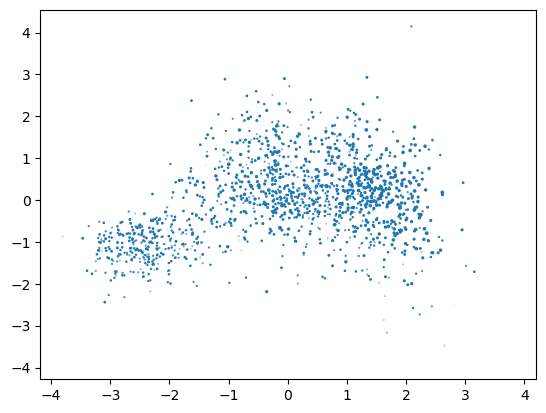

In [44]:
plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], embeddings_pca[:, 2])
plt.show()

In [22]:
embeddings_df = pd.DataFrame(embeddings_pca, columns=['x', 'y', 'z'])

In [23]:
# Create a line plot
scatter_plot = alt.Chart(embeddings_df).mark_point().encode(
    y=alt.Y('y', type="quantitative"),
    x=alt.X('x', type="quantitative"),
).properties(
    title='Scatter plot of entity embeddings - PCA'
)

scatter_plot.properties(width=800, height=600)

alt.Chart(...)

In [24]:
fig = px.scatter_3d(embeddings_df, x='x', y='y', z='z')
fig.update_traces(marker=dict(size=1))
fig.show()

In [65]:
tsne = TSNE(n_components=3)
embeddings_tsne = tsne.fit_transform(np.array(entities_embeddings))

In [66]:
tsne_embeddings_df = pd.DataFrame(embeddings_tsne, columns=['x', 'y', 'z'])

In [63]:
# Create a line plot
scatter_plot = alt.Chart(tsne_embeddings_df).mark_point().encode(
    y=alt.Y('y', type="quantitative"),
    x=alt.X('x', type="quantitative"),
).properties(
    title='Scatter plot of entity embeddings - T-SNE'
)

scatter_plot.properties(width=800, height=600)

alt.Chart(...)

In [68]:
fig = px.scatter_3d(tsne_embeddings_df, x='x', y='y', z='z')
fig.update_traces(marker=dict(size=2))
fig.show()

# Clustering

In [41]:
all_embeddings = []
all_embedding_counts = []
for entity in embeddings_dict:
    for i in range(entities_freq_filtered[entity]):
        all_embeddings.append(embeddings_dict[entity])
        all_embedding_counts.append(entities_freq_filtered[entity])

In [43]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(entities_embeddings)

In [148]:
sse_list = []
silhouette_list = []

for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state=6)
    kmeans.fit(X_minmax, sample_weight=embedding_counts)
    sse_list.append(kmeans.inertia_)
    silhouette_list.append(silhouette_score(X_minmax, kmeans.labels_))

In [149]:
sse_df = pd.DataFrame([(sse_list[k], k+2) for k in range(0, 19)], columns=['sse', "k"])
silhouette_df = pd.DataFrame([(silhouette_list[k], k+2) for k in range(0, 19)], columns=['silhouette', "k"])

In [150]:
# Create a line plot
sse_plot = alt.Chart(sse_df).mark_line().encode(
    y=alt.Y('sse', type="quantitative", scale=alt.Scale(zero=False)),
    x=alt.X('k', type="quantitative"),
).properties(
    title='SSE'
)

sse_plot.properties(width=800, height=600)

alt.Chart(...)

In [151]:
silhouette_plot = alt.Chart(silhouette_df).mark_line().encode(
    y=alt.Y('silhouette', type="quantitative", scale=alt.Scale(zero=False)),
    x=alt.X('k', type="quantitative"),
).properties(
    title='Silhouette'
)

silhouette_plot.properties(width=800, height=600)

alt.Chart(...)

In [152]:
kmeans = KMeans(n_clusters=8, n_init=10, max_iter=100, random_state=6)
kmeans.fit(X_minmax, sample_weight=embedding_counts)

KMeans(max_iter=100, n_init=10, random_state=6)

In [153]:
centers = kmeans.cluster_centers_

def find_closest_vector(target_vector, vectors):
    # Compute the Euclidean distance from the target vector to all other vectors
    distances = np.linalg.norm(vectors - target_vector, axis=1)
    # Identify the index of the closest vector
    closest_index = np.argmin(distances)
    # Retrieve the closest vector
    closest_vector = vectors[closest_index]
    return closest_vector, closest_index

In [154]:
entity_centers = []
for center in centers:
    closest_vector, closest_index = find_closest_vector(scaler.inverse_transform(center.reshape(1, -1)), np.array(entities_embeddings))
    closest_entity = embeddings_entities_dict[tuple(closest_vector)]
    entity_centers.append(closest_entity)

In [155]:
entity_centers

['Latte',
 'Società (sociologia)',
 'Sindacato',
 'Silvano Ridi',
 'Mercato',
 'Agricoltura',
 'Italia',
 'Dio']

In [156]:
embeddings_df = pd.DataFrame(embeddings_pca, columns=['x', 'y', 'z'])
embeddings_df["color"] = kmeans.labels_

In [158]:
# Create a scatter plot
scatter_plot = alt.Chart(embeddings_df).mark_point().encode(
    y=alt.Y('y', type="quantitative"),
    x=alt.X('x', type="quantitative"),
    color=alt.Color('color', type="nominal")
).properties(
    title='Scatter plot of entity embeddings with clusters- PCA'
)

scatter_plot.properties(width=800, height=600)

alt.Chart(...)

In [165]:
def def_value(): 
    return 0
cluster_dimensions = defaultdict(def_value)
i = 0
for embedding in entities_embeddings:
    entity = embeddings_entities_dict[tuple(embedding)]
    cluster = kmeans.labels_[i]
    cluster_dimensions[cluster] = cluster_dimensions[cluster] + entities_freq_filtered[entity]
    i = i + 1
    

In [166]:
dict(cluster_dimensions)

{0: 17306, 4: 10420, 3: 22507, 1: 13257, 6: 21638, 2: 8726, 7: 6506, 5: 10523}

In [167]:
Counter(kmeans.labels_)

Counter({3: 1303, 0: 338, 2: 149, 1: 102, 4: 100, 6: 86, 7: 43, 5: 10})

In [176]:
i = 0
for embedding in entities_embeddings:
    entity = embeddings_entities_dict[tuple(embedding)]
    cluster = kmeans.labels_[i]
    if cluster == 3:
        print(entity)
    i = i + 1

Molise
Cambiamento climatico
Riscaldamento globale
Amazzonia
Provincia di Avellino
Inseminazione artificiale
Teoria del complotto sulle scie chimiche
HAARP (album)
Antartide
Provincia di Teramo
Città metropolitana di Milano
Scia di condensazione
Tibet
Impero austro-ungarico
Abruzzo
Tik Tok
Facebook
Serra de' Conti
Provincia di Ancona
Provincia di Sondrio
Siberia
Provincia di Prato
High Frequency Active Auroral Research Program
YouTube
Giuramento di Ippocrate
Mario Draghi
Unione europea
Camorra
'Ndrangheta
Sacra corona unita
Governo della Repubblica Italiana
Movimento 5 Stelle
Toscana
Natale
Marche
Terra dei fuochi
Emilia-Romagna
Amen.
Puerto Maldonado
Madre de Dios (fiume)
Perù
Parlamento europeo
Provincia di Siena
Lira italiana
Camera dei deputati
Organizzazione mondiale della sanità
Provincia di Novara
Bangladesh
Standa
Internet
Provincia di Milano
Nessuno è solo
Compagnia di Gesù
Ankara
Panino imbottito
Provincia di Treviso
Euro
Lobbi
Fratelli d'Italia - Alleanza Nazionale
Bruxelles